In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arc import *
import pickle
import scipy.optimize as opt
import scipy
from budget_monte_carlo import *
from phase_noise import procData, p0dict_638
import pandas as pd

In [2]:
h = 6.626e-34
e = 1.602e-19
a0 = 5.291e-11
hbar = h/2/np.pi
EH = 4.359744e-18
c = 299792458
kb = 1.380649e-23
me = 9.1093837e-31
epi0 = 8.854e-12
bohr_r = 5.291e-11


<h2>Configuration</h2>

In [3]:
atom_name = 'Cs'
n=50
l = 1
j = 3/2
mj = 3/2

atom_d = 2.5 #um
Omega_Rabi= 1.5*2*np.pi  #MHz
Bz = 10 #G
pulse_time= 7.65 #Omega_Rabi
resolution = 100 # number of phase steps in the pulse
w0_rydberg = 5 #um
lambda_rydberg = 0.319 #um

HF_split = 500*np.pi*2 # MHz
HF_split = None #if mj=1/2 split is from B-field

T_atom = 17 #uK
trap_depth = 300 #uK
lambda_trap = 1.064 #um
w0_trap = 1.2 #um

edc_fluc = 2e-3 #V/cm
edc_zero = 0 #V/m

bdc_fluc = 1e-3 #G

num_samples =10000

phase_noise_csv = "638-narrower-scan_28-7-2025.csv"
RIN_csv_path = 'UV_Intensity_Nov25.csv' 
intensity_DC_V = 10.105

In [4]:
if atom_name == "Rb":
    atom = Rubidium()
elif atom_name == "Cs":
    atom = Caesium()
blockade_mrad = find_blockade_Mrad(atom_name, n, atom_d)
print('Blockade:', blockade_mrad/2/np.pi , 'MHz')
R_lifetime = atom.getStateLifetime(n=n,l=l,j=j,temperature=300, includeLevelsUpTo=n+20,s=0.5)*1e6
m_atom = atom.mass
if HF_split is None:
    HF_split = atom.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=Bz/10000)/hbar/1e6

Blockade: 7.547593190340064 MHz


<h2>Find optimized phase</h2>

In [5]:
H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
PhaseGuess = [2*np.pi*0.1122, 1.0431, -0.7318, 0]
time, phase_guess, dt = phase_cosine_generate(*PhaseGuess, H_gen.pulse_time,H_gen.resolution)
# fid_optimize(PhaseGuess, H_gen)
# H_gen.return_fidel
fid, global_phi = H_gen.return_fidel(phases=phase_guess, dt=dt)
print('Infidelity before optimizer:', 1-fid)
opt_out=opt.minimize(fun=fid_optimize,x0=PhaseGuess,args=(H_gen))
phase_params = opt_out.x
# print(phase_params)
infid_TO = opt_out.fun
print('Infidelity after optimizer:', infid_TO) 
print('phase parameter', phase_params)
##%%


Infidelity before optimizer: 0.028824207933536905
Infidelity after optimizer: 0.0034483915270594467
phase parameter [ 0.92203016  0.91111328 -1.22738109 -0.02921375]


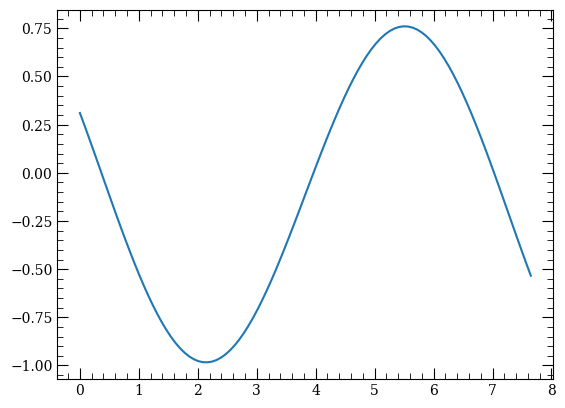

In [6]:
time, phase, dt = phase_cosine_generate(*phase_params, H_gen.pulse_time,H_gen.resolution)
fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
plt.plot(time, phase)

<h2>Budget_calculation</h2>

In [7]:
doppler_shift = 1/lambda_trap/1e-6*np.sqrt(kb*(T_atom*1e-6)/m_atom)
print('doppler shift:', doppler_shift/2/np.pi, 'Hz')

calc = StarkMap(atom)
calc.defineBasis(n=n, l=1, j=1.5, mj=1.5, nMin=n-20, nMax=n+30, maxL=5, Bz=Bz/10000)
calc.diagonalise(np.linspace(0,60,600))
pol_dc = calc.getPolarizability(debugOutput=True)
edc_zero = 0
delta_edc = abs(-1/2*pol_dc*1e6*((edc_zero+edc_fluc)**2-edc_zero**2))*2*np.pi 
print('Electric DC fluctuation:', delta_edc/2/np.pi, 'Hz')

delta_bdc = atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=bdc_fluc/10000)/hbar
print('Magnetic DC fluctuation:', delta_bdc/2/np.pi, 'Hz')

total_shift = np.sqrt(delta_bdc**2+ delta_edc**2 + doppler_shift**2)
print('Total DC detuning fluctuation:', total_shift/2/np.pi, 'Hz')
detunings = total_shift/1e6/Omega_Rabi
print('delta/Ω:', detunings)
print('==============')
infids_s = []
for i in range(num_samples):
    d = sample_gaussian(detunings)
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=d, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
    infids_s.append(1-fid)
infids_s = np.asarray(infids_s)
infids_detuning = np.mean(infids_s)-infid_TO
infids_detiuning_std = infids_s.std(ddof=1)
print(f'total error due to detuning: {infids_detuning} +/- {infids_detiuning_std}')

infids_s = []
infids_blockade = []
infids_rabi = []
sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
ds, c1, c2, = sample_pair_distances(
        n_samples=num_samples,
        sigma_r=sigma_r,
        sigma_z=sigma_z,
        x_offset=atom_d,
        rng=None
)
x1 = c1['x']
y1 = c1['y']
z1 = c1['z']
x2 = c2['x']
y2 = c2['y']
z2 = c2['z']
rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi

for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade = find_blockade_Mrad(atom_name, n, d)
    # total
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                     Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_s.append(1-fid)

    H_gen_block = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen_block.asym_return_fidel(phases=phase, dt=dt, omega1_scale=1, omega2_scale=1)
    infids_blockade.append(1-fid)

    H_gen_rabi = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                 Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    fid, global_phi = H_gen_rabi.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
    infids_rabi.append(1-fid)
infids_s = np.asarray(infids_s)
infids_motion = np.mean(infids_s) - infid_TO
infids_motion_std = infids_s.std(ddof=1)

infids_blockade = np.asarray(infids_blockade)
infids_motion_blockade = np.mean(infids_blockade) - infid_TO
infids_motion_blockade_std = infids_blockade.std(ddof=1)

infids_rabi = np.asarray(infids_rabi)
infids_motion_rabi = np.mean(infids_rabi) - infid_TO
infids_motion_rabi_std = infids_rabi.std(ddof=1)

print(f'total error due to atom motion: {infids_motion} +/- {infids_motion_std}')
print(f'total error due to atom motion(blockade): {infids_motion_blockade} +/- {infids_motion_blockade_std}')
print(f'total error due to atom motion(rabi): {infids_motion_rabi} +/- {infids_motion_rabi_std}')

# delta_mj = atom.getZeemanEnergyShift(l=1, j=3/2, mj=3/2, magneticFieldBz=Bz/10000)/hbar/1e6 - \
# atom.getZeemanEnergyShift(l=1, j=3/2, mj=1/2, magneticFieldBz=Bz/10000)/hbar/1e6
leakage_mj  = (Omega_Rabi)**2/((Omega_Rabi)**2+HF_split**2)
print(f'eror due to leakage_mj:{leakage_mj}')

loss_decay = (2.95/(Omega_Rabi))/R_lifetime
print('error due to Rydberg decay:', loss_decay)



###
phase_noise_data = procData(phase_noise_csv, True, "638nm", range=1e6, p0=p0dict_638)
label = phase_noise_data[1][1]
vnoise_data = phase_noise_data[1][0]
vnoise_fs = []
vnoise_W = []
for d in vnoise_data:
    if d[0] >=0:
        vnoise_fs.append(d[0]/1e6)
        vnoise_W.append(d[1]*d[0]**2)
# fig, ax = plt.subplots()
# ax.plot(vnoise_fs, vnoise_W, label=label)
# ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_ylabel('Frequency PSD [Hz$^2$/Hz]')
# ax.set_xlabel('frequency [MHz]')
vnoise_fs= np.array(vnoise_fs)
vnoise_W = np.array(vnoise_W)
Omega_Rabi = 1*2*np.pi
vnoise_contribution = []

# fs  = np.linspace(0,15,500)
# for f in fs:
for i in range(len(vnoise_fs)-1):
    deltaf = vnoise_fs[i+1]-vnoise_fs[i]
    If = gv(vnoise_fs[i]*2*np.pi/Omega_Rabi)/Omega_Rabi**2*4*np.pi*np.pi
    vnoise_contribution.append(If*vnoise_W[i]*deltaf/1e6)
# plt.plot(f[:-1], vnoise_contribution)
vnoise_error = np.sum(vnoise_contribution)
print('error due to laser phase noise:', vnoise_error)


intensity_noise_csv = pd.read_csv(RIN_csv_path, header=None)

fs_intensity = intensity_noise_csv[0]
RIN_db = intensity_noise_csv[1]
rbw = fs_intensity[1]-fs_intensity[0]
carrier_p = (intensity_DC_V**2/50)
RIN_dbc = (RIN_db-w_to_db(carrier_p)-w_to_db(rbw)) #convert to dBc/Hz= db(W_RIN/W_carrier/Hz) = db(W_RIN)-db(W_carrier)-db(Hz) 

# fig , ax = plt.subplots(ncols=2)
# ax[0].plot(fs_intensity, RIN_dbc)
# ax[0].plot(fs_intensity, RIN_db)
RIN_W = db_to_w(RIN_dbc)
fs_intensity = np.array(fs_intensity)
RIN_W = np.array(RIN_W)
Omega_Rabi = 1*2*np.pi
RIN_contribution = []

# fs  = np.linspace(0,15,500)
# for f in fs:
for i in range(len(fs_intensity)-1):
    deltaf = fs_intensity[i+1]-fs_intensity[i]
    Ii = gi(fs_intensity[i]/1e6*2*np.pi/Omega_Rabi)
    RIN_contribution.append(Ii*RIN_W[i]*deltaf)
# plt.plot(fs[:-1], contribution)
RIN_error = np.sum(RIN_contribution)
print('error due to RIN:', RIN_error)


total_error = loss_decay + leakage_mj + infids_motion + infids_detuning+ RIN_error + vnoise_error
print('total error:', total_error)

doppler shift: 4878.0770788254995 Hz
finding original state for each electric field value
found  599
Scalar polarizability =  1102.6969478173237  MHz cm^2 / V^2 
Electric DC fluctuation: 2205.3938956346474 Hz
Magnetic DC fluctuation: 2800.901714064941 Hz
Total DC detuning fluctuation: 6041.891147125808 Hz
delta/Ω: 0.004027927431417205
total error due to detuning: 6.276637121507833e-07 +/- 8.904298111296597e-07
total error due to atom motion: 0.03656039217291172 +/- 0.08127982813089701
total error due to atom motion(blockade): 0.03750381865451716 +/- 0.08600941616408062
total error due to atom motion(rabi): 0.0033791504758801053 +/- 0.007462832250635485
eror due to leakage_mj:0.02516293650074821
error due to Rydberg decay: 0.003161715612106158


/Users/linipunphuttitarn/Documents/Physics/AQUA/GateErrorSim/phase_noise.py:219: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(white_noise + bump_noise + nf)


error due to laser phase noise: 7.467062441966722e-05
error due to phase noise: 0.0008556932092556828
total error: 0.06581603578315358


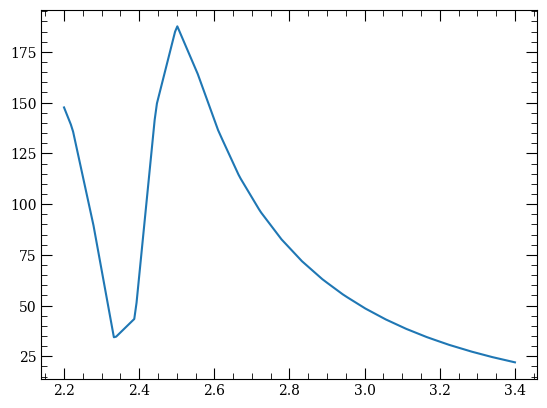

In [8]:
x = np.linspace(2.2, 3.4, 200)
blockade = [find_blockade_Mrad(atom_name, 65, y)/2/np.pi for y in x]
plt.plot(x,blockade)

(array([7.000e+00, 5.900e+01, 2.950e+02, 1.067e+03, 2.082e+03, 2.307e+03,
        1.808e+03, 1.069e+03, 5.540e+02, 2.970e+02, 1.940e+02, 1.180e+02,
        6.100e+01, 3.600e+01, 1.600e+01, 9.000e+00, 1.400e+01, 3.000e+00,
        2.000e+00, 2.000e+00]),
 array([1.8690444 , 2.00777759, 2.14651077, 2.28524396, 2.42397714,
        2.56271033, 2.70144352, 2.8401767 , 2.97890989, 3.11764307,
        3.25637626, 3.39510944, 3.53384263, 3.67257581, 3.811309  ,
        3.95004218, 4.08877537, 4.22750855, 4.36624174, 4.50497493,
        4.64370811]),
 <BarContainer object of 20 artists>)

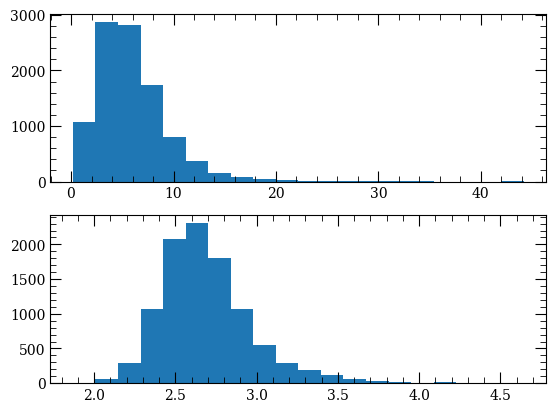

In [9]:
blockade = []
for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
    blockade.append(find_blockade_Mrad(atom_name, n, d)/2/np.pi)
fig, ax = plt.subplots(nrows=2)
ax[0].hist(blockade, bins=20)
ax[1].hist(ds, bins=20)

<h2>Shot-to-shot detuning</h2>

In [10]:
deltas = np.linspace(0,0.1, 100)
deltas *= Omega_Rabi
infids_mean = []
infids_std  = []
for delta in deltas:
    infids_s = []
    for i in range(num_samples):
        d = sample_gaussian(delta)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=d, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

KeyboardInterrupt: 

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fractional_delta = deltas/Omega_Rabi
fig, ax = plt.subplots()
ax.plot(fractional_delta, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    fractional_delta,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Delta_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)
# fig.show()
# ax.legend()

In [ ]:
fig, ax = plt.subplots(nrows=2)

ax[0].hist(params, density=True)
ax[1].hist(infids, density= True)
print(np.mean(params))
print(np.mean(infids))

<h2>shot-to-shot Blockade</h2>

In [ ]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    distances = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )[0]
    for d in distances:
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>shot-to-shot Intensity</h2>

In [ ]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []
    H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    d, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2 in zip(rabis1, rabis2):
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(T_atoms, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    T_atoms,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$T(\mu K)$", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

In [ ]:
delta_omegas = np.linspace(0,0.1, 100)
infids_mean = []
infids_std  = []
for delta_omega in delta_omegas:
    infids_s = []
    for i in range(num_samples):
        omega_scaled = sample_gaussian(delta_omega)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade_mrad, r_lifetime=R_lifetime, Delta1=0, 
                             Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.return_fidel(phases=phase, dt=dt, omega_scale=(1-omega_scaled))
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

In [ ]:
infids_mean = np.asarray(infids_mean)
infids_std  = np.asarray(infids_std)
sem = infids_std / np.sqrt(num_samples)
fig, ax = plt.subplots()
ax.plot(delta_omegas, infids_mean, label="mean(1 - fid)")
ax.fill_between(
    delta_omegas,
    infids_mean - sem,
    infids_mean + sem,
    alpha=0.25,
    label="±1 std"
)
ax.set_xlabel(r"$\delta \Omega_{DC}/ \Omega $", fontsize=20)
ax.set_ylabel("$1 - \mathcal{F}$", fontsize=20)

<h2>Atom motion</h2>

In [ ]:
infids_mean = []
infids_std  = []
T_atoms = np.linspace(5,20,100)
for T_atom in T_atoms:
    infids_s = []

    sigma_r = sigma_r_um(T_atom, trap_depth, w0_trap)
    sigma_z = sigma_z_um(T_atom, trap_depth, w0_trap, lambda_trap)
    ds, c1, c2, = sample_pair_distances(
            n_samples=num_samples,
            sigma_r=sigma_r,
            sigma_z=sigma_z,
            x_offset=atom_d,
            rng=None
    )
    
    x1 = c1['x']
    y1 = c1['y']
    z1 = c1['z']
    x2 = c2['x']
    y2 = c2['y']
    z2 = c2['z']
    rabi = np.sqrt(relative_gaussian_beam_intensity(0, 0, 0-atom_d/2, w0_rydberg, lambda_rydberg))
    rabis1 = np.sqrt(relative_gaussian_beam_intensity(x1, z1, y1-atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    rabis2 = np.sqrt(relative_gaussian_beam_intensity(x2-atom_d, z2, y2+atom_d/2, w0_rydberg, lambda_rydberg))/rabi
    for rabi1, rabi2, d in zip(rabis1, rabis2, ds):
        blockade = find_blockade_Mrad(atom_name, n, d)
        H_gen = Hamiltonians(Omega_Rabi1=Omega_Rabi, blockade_inf=False, blockade=blockade, r_lifetime=R_lifetime, Delta1=0, 
                         Stark1=0, Stark2=0, resolution=resolution, r_lifetime2=R_lifetime, pulse_time=pulse_time)
        fid, global_phi = H_gen.asym_return_fidel(phases=phase, dt=dt, omega1_scale=rabi1, omega2_scale=rabi2)
        infids_s.append(1-fid)
    infids_s = np.asarray(infids_s)
    infids_mean.append(np.mean(infids_s))
    infids_std.append(infids_s.std(ddof=1))

<h2>Read infdel</h2>

In [ ]:
result = np.load('results/infid_raw.npz')

In [ ]:
print(result['x_detuning'])

<h2>Laser noise</h2>

<h2>Stark shift</h2>

In [ ]:
inter_detuning = 5e3*2*np.pi #MHz
Omega1 = np.sqrt(Omega_Rabi*inter_detuning)
omega_photon1 = atom.getTransitionFrequency(n1=6, l1=0, j1=1/2, n2=7, l2=1, j2=1/2, s=0.5)
omega_photon1 += inter_detuning/2/np.pi

d_blue = atom.getDipoleMatrixElement(n1=6, l1=0, j1=1/2, mj1=-1/2, n2=7, l2=1, j2=1/2, mj2=1/2,q=1, s=0.5)*bohr_r/hbar*e
d_red = atom.getDipoleMatrixElement(n1=7, l1=1, j1=1/2, mj1=1/2, n2=n, l2=0, j2=1/2, mj2=-1/2,q=-1, s=0.5)*bohr_r/hbar*e
alpha_g_gen = DynamicPolarizability(atom, n=6, l=0, j=1/2, s=0.5)
alpha_g_gen.defineBasis(6, 9)
alpha_g = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=7, l=1, j=1/2, s=0.5)
alpha_e_gen.defineBasis(6, 9)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

alpha_e_gen = DynamicPolarizability(atom, n=60, l=0, j=1/2, s=0.5)
alpha_e_gen.defineBasis(7, 75)
alpha_e = alpha_g_gen.getPolarizability(c/omega_photon1, units='SI', accountForStateLifetime=False, mj=None)

In [ ]:
alpha_g